## Converting the Case 1 in the 18S096 from R to Python

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import plot_leverage_resid2, influence_plot
import seaborn as sns

                            OLS Regression Results                            
Dep. Variable:            r_GE_excess   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9946
Date:                Sun, 29 Jun 2025   Prob (F-statistic):              0.320
Time:                        18:14:33   Log-Likelihood:                 835.87
No. Observations:                 260   AIC:                            -1668.
Df Residuals:                     258   BIC:                            -1661.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           9.278e-05      0.001      0.

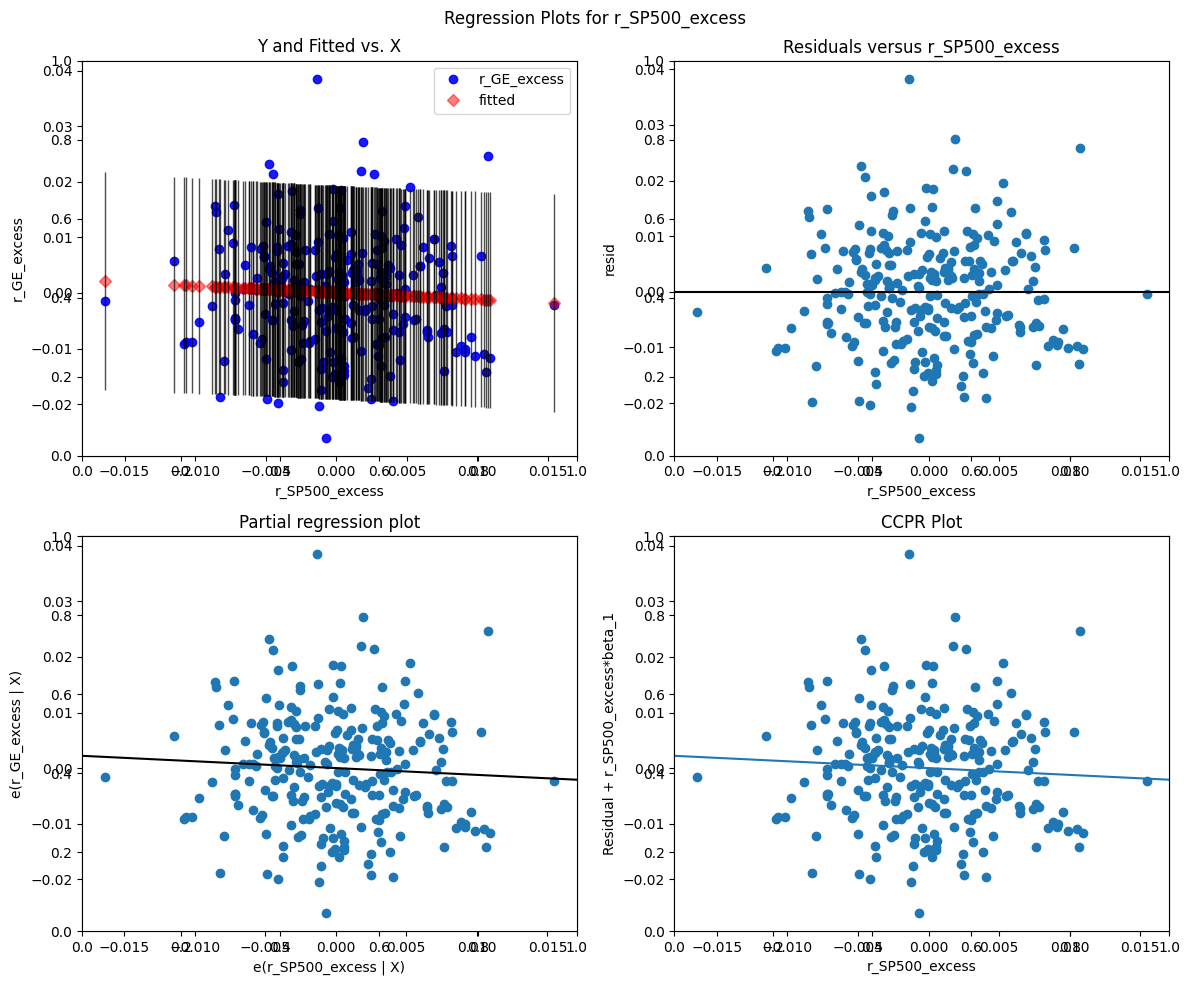

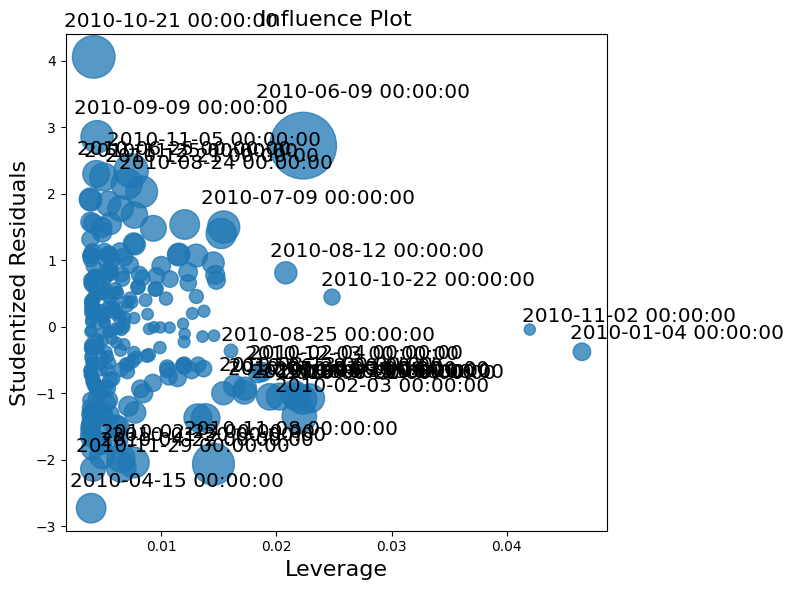

                            OLS Regression Results                            
Dep. Variable:            r_GE_excess   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.6185
Date:                Sun, 29 Jun 2025   Prob (F-statistic):              0.540
Time:                        18:14:33   Log-Likelihood:                 836.00
No. Observations:                 260   AIC:                            -1666.
Df Residuals:                     257   BIC:                            -1655.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0001      0.001      0.

In [4]:
# --- Step 1: Load Data ---
# Replace with your actual CSV file
df = pd.read_csv('casestudy1_data.csv', parse_dates=True, index_col=0)
df = df.sort_index()

# Drop rows with missing data for simplicity
df = df.dropna(subset=['GE', 'SP500', 'DGS3MO', 'DCOILWTICO'])

# --- Step 2: Compute Log Returns ---
df['r_GE'] = np.log(df['GE'] / df['GE'].shift(1))
df['r_SP500'] = np.log(df['SP500'] / df['SP500'].shift(1))

# --- Step 3: Compute Risk-Free Return ---
days_diff = df.index.to_series().diff().dt.days.fillna(1)
df['r_rf'] = np.log(1 + 0.01 * df['DGS3MO'] * (days_diff / 360))

# --- Step 4: Excess Returns ---
df['r_GE_excess'] = df['r_GE'] - df['r_rf']
df['r_SP500_excess'] = df['r_SP500'] - df['r_rf']
df['r_DCOILWTICO'] = df['DCOILWTICO'].diff() / df['DCOILWTICO'].shift(1)

df = df.dropna()

# --- Step 5: CAPM Regression (GE ~ SP500 Excess) ---
X = sm.add_constant(df['r_SP500_excess'])
y = df['r_GE_excess']
model_capm = sm.OLS(y, X).fit()
print(model_capm.summary())

# --- Step 6: Diagnostic Plots ---
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
sm.graphics.plot_regress_exog(model_capm, 'r_SP500_excess', fig=fig)
plt.tight_layout()
plt.show()

# Leverage & Influence
fig, ax = plt.subplots(figsize=(8, 6))
influence_plot(model_capm, ax=ax)
plt.tight_layout()
plt.show()

# --- Step 7: Extended CAPM (GE ~ SP500 Excess + Oil Returns) ---
X_ext = sm.add_constant(df[['r_SP500_excess', 'r_DCOILWTICO']])
model_ext = sm.OLS(df['r_GE_excess'], X_ext).fit()
print(model_ext.summary())

# --- Step 8: Repeat for XOM if you want ---
# Same process as above, using df['XOM'] instead of df['GE']
